In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

## Set of constants

In [27]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=30
EPOCHS=30
data_dir = "FIDS302"

## Importing the Dataset

In [28]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 971 files belonging to 30 classes.


In [29]:
class_names = dataset.class_names
print(len(class_names))
class_names

30


['acerolas',
 'apples',
 'apricots',
 'avocados',
 'bananas',
 'blackberries',
 'blueberries',
 'cantaloupes',
 'cherries',
 'coconuts',
 'figs',
 'grapefruits',
 'grapes',
 'guava',
 'kiwifruit',
 'lemons',
 'limes',
 'mangos',
 'olives',
 'oranges',
 'passionfruit',
 'peaches',
 'pears',
 'pineapples',
 'plums',
 'pomegranates',
 'raspberries',
 'strawberries',
 'tomatoes',
 'watermelons']

## Preprocess the Dataset

In [30]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 5 11 27 21 24 19  3 22  6 14 11 19 17 24 11 21 22 12 21 17  4 22  5 25
  1  8 25  6  4 21 23 18]


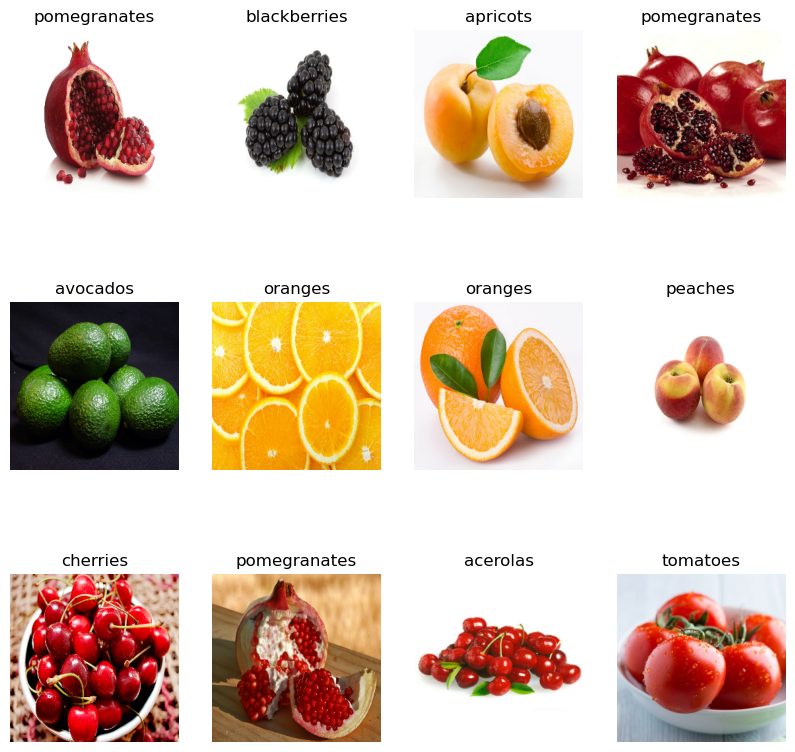

In [31]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


#### Splitting the dataset

In [32]:
len(dataset)

31

In [33]:
train_size = 0.8
len(dataset)*train_size

24.8

In [34]:
train_ds = dataset.take(24)
len(train_ds)

24

In [35]:
test_ds = dataset.skip(24)
len(test_ds)

7

In [36]:
val_size=0.1
len(dataset)*val_size

3.1

In [37]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [38]:
test_ds = test_ds.skip(3)
len(test_ds)

4

In [39]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [40]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [41]:
len(train_ds)

24

In [42]:
len(val_ds)

3

In [43]:
len(test_ds)

4

## Cache, Shuffle, and Prefetch the Dataset

In [44]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization

In [45]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [46]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [47]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

In [60]:
num_classes = 30

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [61]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [63]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/30
24/24 [==============================] - 92s 4s/step - loss: 2.0958 - accuracy: 0.3464 - val_loss: 2.1580 - val_accuracy: 0.3229
Epoch 2/30
24/24 [==============================] - 91s 4s/step - loss: 2.0006 - accuracy: 0.3711 - val_loss: 1.9882 - val_accuracy: 0.3958
Epoch 3/30
24/24 [==============================] - 90s 4s/step - loss: 1.7015 - accuracy: 0.4531 - val_loss: 1.5522 - val_accuracy: 0.4896
Epoch 4/30
24/24 [==============================] - 93s 4s/step - loss: 1.5565 - accuracy: 0.4753 - val_loss: 1.4923 - val_accuracy: 0.5833
Epoch 5/30
24/24 [==============================] - 91s 4s/step - loss: 1.4195 - accuracy: 0.5339 - val_loss: 1.3287 - val_accuracy: 0.6042
Epoch 6/30
24/24 [==============================] - 102s 4s/step - loss: 1.2778 - accuracy: 0.5534 - val_loss: 1.3677 - val_accuracy: 0.5729
Epoch 7/30
24/24 [==============================] - 108s 5s/step - loss: 1.1729 - accuracy: 0.6289 - val_loss: 1.3147 - val_accuracy: 0.5938
Epoch 8/30
24/24 [

In [64]:
scores = model.evaluate(test_ds)

2023-04-02 04:41:00.800858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-02 04:41:07.394902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-02 04:41:07.395541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 17 of 10000
2023-04-02 04:41:08.625907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-02 04:41:09.008926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-04-02 04:41:09.009484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-04-02 04:41:09.009892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


4/4 [==============================] - 15s 778ms/step - loss: 0.7314 - accuracy: 0.8281


### Evaluation

In [66]:
# Scores is just a list containing loss and accuracy value
scores

[0.7313752174377441, 0.828125]

### Saving the Model

In [69]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1/assets


INFO:tensorflow:Assets written to: ./models/1/assets
